In [1]:
from models import *
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import Tensor
from pytorch_lightning.utilities.seed import seed_everything
from sklearn.preprocessing import MinMaxScaler
from typing import Optional
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from UT_Helper import plot_1d_function


Welcome to JupyROOT 6.26/06


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


In [3]:
class Simple_MLP(nn.Module):
    def __init__(self, input_dim, units):
        super(Simple_MLP, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, units)#.to(device)
        self.activation = nn.Tanh()
        self.linear2 = nn.Linear(units, 1, bias=False)#.to(device)
        
    def forward(self, x):
        return self.linear2(self.activation(self.linear1(x)))

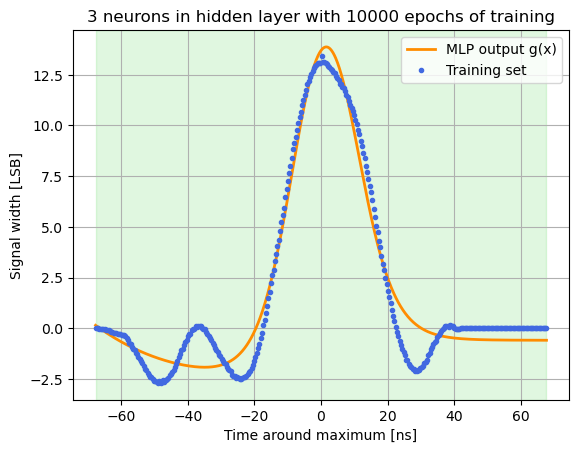

In [4]:
EPOCHS = 10000
UNITS = 3

data = np.genfromtxt("400V_5C.txt")
min_x, max_x = [f(data[:,0]) for f in [np.min, np.max]]

x_train = np.reshape(data[:,0], (-1,1))  
y_train = np.reshape(data[:,1], (-1,1))  
x_eval = np.reshape(np.linspace(x_train[0], x_train[-1], 1000), (-1,1))

x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaled = x_scaler.fit_transform(x_train)
y_scaled = y_scaler.fit_transform(y_train)
x_eval_scaled = x_scaler.transform(x_eval)

x_train_tensor = torch.from_numpy(x_scaled).float()#.to(device)
x_eval_tensor = torch.from_numpy(x_eval_scaled).float()#.to(device)
y_train_tensor = torch.from_numpy(y_scaled).float()#.to(device)  

MLP = Simple_MLP(input_dim = 1, units = UNITS).to(device)
optimizer = optim.Adam(MLP.parameters())
loss_fn = nn.MSELoss(reduction='mean')

for epoch in range(EPOCHS):
        yhat = MLP(x_train_tensor)
            
        loss = loss_fn(yhat, y_train_tensor)
        
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()
        
y_eval = y_scaler.inverse_transform(MLP(x_eval_tensor).detach().numpy())
fig, ax = plot_1d_function(x_train, y_train, x_eval, y_eval, UNITS, 10000);
fig.savefig("2.pdf")

Rozkłady wysokości maksimów
Rozkłady szerokości maksimów od -20 do 20 (FWHM liczone z RMS)

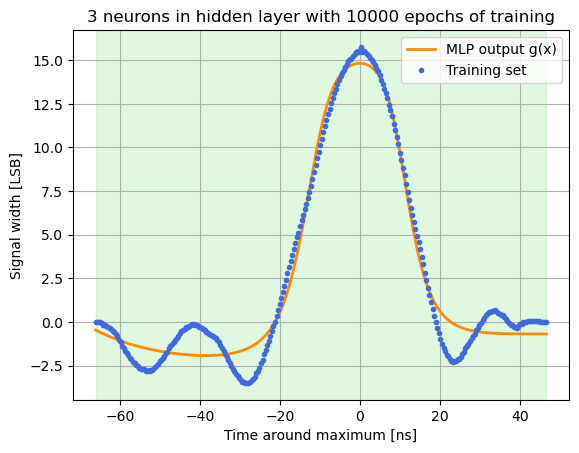

In [39]:
EPOCHS = 10000
UNITS = 3

data = np.genfromtxt("200V_-15C.txt")
min_x, max_x = [f(data[:,0]) for f in [np.min, np.max]]

x_train = np.reshape(data[:,0], (-1,1))  
y_train = np.reshape(data[:,1], (-1,1))  
x_eval = np.reshape(np.linspace(x_train[0], x_train[-1], 1000), (-1,1))

x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaled = x_scaler.fit_transform(x_train)
y_scaled = y_scaler.fit_transform(y_train)
x_eval_scaled = x_scaler.transform(x_eval)

x_train_tensor = torch.from_numpy(x_scaled).float()#.to(device)
x_eval_tensor = torch.from_numpy(x_eval_scaled).float()#.to(device)
y_train_tensor = torch.from_numpy(y_scaled).float()#.to(device)  

MLP = Simple_MLP(input_dim = 1, units = UNITS).to(device)
optimizer = optim.Adam(MLP.parameters())
loss_fn = nn.MSELoss(reduction='mean')

for epoch in range(EPOCHS):
        yhat = MLP(x_train_tensor)
            
        loss = loss_fn(yhat, y_train_tensor)
        
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()
        
y_eval = y_scaler.inverse_transform(MLP(x_eval_tensor).detach().numpy())
fig, ax = plot_1d_function(x_train, y_train, x_eval, y_eval, UNITS, 10000);

### LIGHTNING (TOO SLOW)

In [16]:
class MLP_DM(pl.LightningDataModule):
    def __init__(self, data_path, x_eval, x_scaler=None, y_scaler = None):
        super().__init__()
        self.data_path = data_path
        self.x_eval = np.reshape(x_eval, (-1,1))
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        
    def setup(self, stage: Optional[str] = None):
        data = np.genfromtxt(self.data_path)
        self.x_train = np.reshape(data[:,0], (-1,1))
        self.y_train  = np.reshape(data[:,1], (-1,1))
        
        if self.x_scaler:
            self.x_scaled = self.x_scaler.fit_transform(self.x_train)
            self.x_eval_scaled = self.x_scaler.transform(self.x_eval)
        if self.y_scaler:
            self.y_scaled = self.y_scaler.fit_transform(self.y_train)
            
        self.train_dataset = TensorDataset(Tensor(self.x_scaled), Tensor(self.y_scaled))
        self.test_dataset = TensorDataset(Tensor(self.x_eval_scaled))
            
    def train_dataloader(self):
        return DataLoader(self.train_dataset, shuffle=False)
    def test_dataloader(self):
        return DataLoader(self.test_dataset, shuffle=False)       
        
     

In [28]:
DM = MLP_DM("400V_5C.txt", x_eval= np.linspace(min_x,max_x,1000), 
               x_scaler=MinMaxScaler(feature_range=(-1, 1)), y_scaler=MinMaxScaler(feature_range=(-1, 1)))
DM.setup()

In [48]:
model = Simple_MLP(input_dim = 1, units = 3)
trainer = Trainer(accelerator='auto', devices = 'auto', max_epochs = 10000, enable_progress_bar=False)
trainer.fit(model, DM)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 9     
1 | mse    | MSELoss    | 0     
--------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)
/opt/anaconda/miniconda3/envs/generative-root/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=10000` reached.


In [49]:
y_eval = DM.y_scaler.inverse_transform(model(Tensor(DM.x_eval_scaled)).detach().numpy())

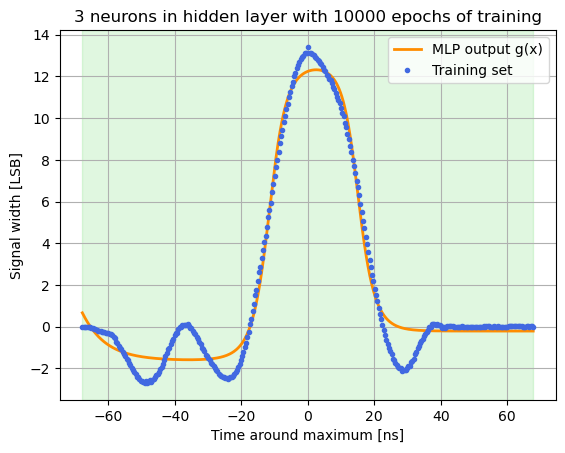

In [54]:
fig, ax = plt.subplots()
ax.axvspan(DM.x_train.flatten()[0], DM.x_train.flatten()[-1], alpha=0.15, color='limegreen')
ax.plot(DM.x_eval, y_eval, '-', color='darkorange', linewidth=2.0, label = 'MLP output g(x)')
ax.plot(DM.x_train, DM.y_train, '.', color='royalblue', label = 'Training set')
ax.grid(which='both');
# ax.rcParams.update({'font.size': 14})
ax.set_xlabel('Time around maximum [ns]');
ax.set_ylabel('Signal width [LSB]')
ax.set_title('%d neurons in hidden layer with %d epochs of training' % (model.units ,trainer.max_epochs))
ax.legend()